### utils/clients

In [1]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

import httpx

# Create HTTP client with verify=False for LangChain
client = httpx.Client(verify=False)


#Required to avoid SSL verification issues with requests in LangChain/creating embeddings/vector stores
import requests
for method in ("get", "post", "put", "delete", "head", "options", "patch"):
    original = getattr(requests, method)

    def insecure_request(*args, _original=original, **kwargs):
        kwargs["verify"] = False
        return _original(*args, **kwargs)

    setattr(requests, method, insecure_request)


def get_llm():
    llm = ChatOpenAI(
    base_url="https://genailab.tcs.in",
    model="azure_ai/genailab-maas-DeepSeek-V3-0324",
    api_key="sk-xA46m6ExMaLX4lRBXz5gfg",
    http_client=client,
    )

    return llm


def get_embeddings():
    return OpenAIEmbeddings(
        base_url="https://genailab.tcs.in",
        model="azure/genailab-maas-text-embedding-3-large",
        api_key="sk-xA46m6ExMaLX4lRBXz5gfg",
        http_client=client,
        )


def get_vector_store(docs):
    embeddings = get_embeddings()
    # vector_store = FAISS.from_documents(documents=docs, embedding=embeddings)
    # vector_store.save_local('faiss_index')
    vector_store = Chroma.from_documents(documents=docs, embedding=embeddings, persist_directory="./chroma_index")
    vector_store.persist()
    return vector_store


c:\Program Files\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### tools

In [2]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model


model = get_llm()


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b





from langchain.agents import create_agent

model = get_llm()

# Augment the LLM with tools
tools = [add, multiply, divide]

arithmetic_system_prompt = (
    "You are an assistant that answers arithmetic questions.\n"
    "You MUST use the provided tools (add, multiply, divide) to compute answers.\n"
    "Show the final answer clearly to the user."
)

arithmetic_agent = create_agent(
    model=model,
    tools=tools,
    system_prompt=arithmetic_system_prompt,
)

# Summary agent: no tools, just summarize history
summary_system_prompt = (
    "You are a summarization assistant.\n"
    "Given the full conversation and tool calls so far, "
    "produce a concise summary of what was done and what the final result was.\n"
    "Write the summary in clear natural language."
)

summary_agent = create_agent(
    model=model,
    tools=[],  # no tools for summarizer
    system_prompt=summary_system_prompt,
)

### state

In [4]:
from langchain.messages import AnyMessage,HumanMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]


def add_summary_request(state: MessagesState) -> dict:
    """
    This node appends a HumanMessage that explicitly asks for a summary.
    Because of the `operator.add` reducer, returning a *new* list of messages
    means it gets appended to the existing state's `messages`.
    """
    return {
        "messages": [
            HumanMessage(
                content="Summarize all the actions and tool calls performed so far, "
                        "and clearly state the final answer."
            )
        ]
    }

### Build and compile the agent

c:\Program Files\Python312\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mermaid.ink'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


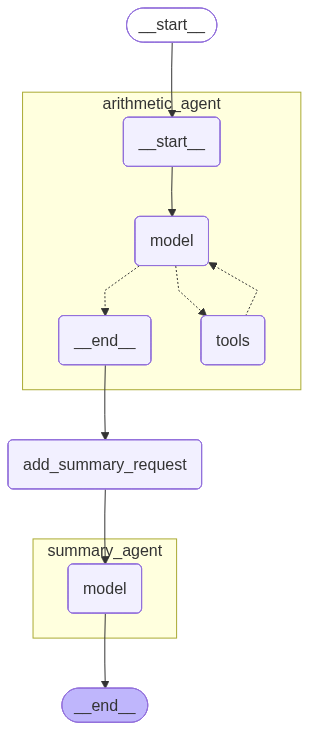

================================ Human Message =================================

Add 3 and 4.
================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_O_Pq7FliSX6lcWPj4htGqw)
 Call ID: call_O_Pq7FliSX6lcWPj4htGqw
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Summarize all the actions and tool calls performed so far, and clearly state the final answer.
================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_O_Pq7FliSX6lcWPj4htGqw)
 Call

In [5]:

from langgraph.graph import StateGraph, START, END
# Build workflow

builder = StateGraph(MessagesState)

# Nodes
builder.add_node("arithmetic_agent", arithmetic_agent)
builder.add_node("add_summary_request", add_summary_request)
builder.add_node("summary_agent", summary_agent)

# Edges / flow:
# START → arithmetic_agent → add_summary_request → summary_agent → END
builder.add_edge(START, "arithmetic_agent")
builder.add_edge("arithmetic_agent", "add_summary_request")
builder.add_edge("add_summary_request", "summary_agent")
builder.add_edge("summary_agent", END)

# Compile graph into a runnable
agent = builder.compile()


# ─────────────────────────────────────────────────────────────
# (Optional) Visualize graph (in notebook)
# ─────────────────────────────────────────────────────────────
if __name__ == "__main__":
    try:
        from IPython.display import Image, display
        display(Image(agent.get_graph(xray=True).draw_mermaid_png()))
    except Exception:
        # If you're not in a notebook, skip visualization
        pass

    # ─────────────────────────────────────────────────────
    # Example Invocation
    # ─────────────────────────────────────────────────────
    user_messages = [HumanMessage(content="Add 3 and 4.")]
    final_state = agent.invoke({"messages": user_messages})

    # Print the final conversation (including summary)
    for m in final_state["messages"]:
        m.pretty_print()